# Building Robust RAG Pipelines: Integrating Google's Gemma 2 2B Open Model, MongoDB, and LLM Evaluation Techniques

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mongodb-developer/GenAI-Showcase/blob/main/notebooks/rag/rag_with_gemma2_2b_mongodb_open_models.ipynb)


You can view an article version of this notebook here:

[![View Article](https://img.shields.io/badge/View%20Article-blue)](https://www.mongodb.com/developer/products/atlas/gemma2b_mongodb_rag/)

What’s covered in this tutorial
- Building an asset management analyst assistant with Gemma 2
- Implementing a RAG pipeline with MongoDB
- Vector search and semantic retrieval techniques
- Generating responses using the Gemma 2 (2B) model
- LLM evaluation for RAG components

### Background

**Problem Statement**

Financial institutions often face difficulties in manually reviewing provided financial statements or advice for regulatory compliance, risking penalties for violations such as unauthorized financial advice.


**Proposed Solution**

A Retrieval-Augmented Generation (RAG) pipeline integrated with Gemma and ShieldGemma, which will automatically analyze the text of these statements against relevant policies. This system will flag potential violations, streamline compliance checks, and reduce human error, helping financial entities avoid costly penalties.



**Use Case**

**Regulatory Compliance Automation for Financial Statements/Advice**



**Value**

This use case significantly reduces the manual effort needed to ensure compliance, lowers the risk of fines, and increases the accuracy and speed of regulatory reviews.



## Step 1: Install libaries and Set Environment Variables


In [1]:
!pip install --upgrade --quiet datasets pandas pymongo sentence_transformers deepeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 829.1 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 103.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 66.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.3/245.3 kB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 389.5/389.5 kB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.7/307.7 kB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.8/50.8 kB 4.1 MB/s eta 0:00:00
   

In [2]:
import getpass
import os

# Make sure you have an Hugging Face token(HF_TOKEN) in your development environemnt before running the code below
# How to get a token: https://huggingface.co/docs/hub/en/security-tokens

HF_TOKEN = getpass.getpass("Enter HF_TOKEN API Key: ")
os.environ["HF_TOKEN"] = HF_TOKEN

Enter HF_TOKEN API Key: ··········


In [3]:
# Need this for the evaluation step.
# Feel free to exclude this if you have your custom evalution methods

OPENAI_API_KEY = getpass.getpass("Enter OPENAI_API_KEY API Key: ")
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

Enter OPENAI_API_KEY API Key: ··········


## Step 2: Data Loading and Preparation

Dataset Information

This [dataset](https://huggingface.co/datasets/MongoDB/fake_tech_companies_market_reports) contains detailed information about multiple technology companies in the Information Technology sector. For each company, the dataset includes:

1. Company name and stock ticker symbol
2. Market analysis reports for recent years (typically 2023 and 2024), which include:
- Title and author of the report
- Date of publication
- Detailed content covering financial performance, product innovations, market position, challenges, and future outlook
- Stock recommendations and price targets
3. Key financial metrics such as:
- Current stock price
- 52-week price range
- Market capitalization
- Price-to-earnings (P/E) ratio
- Dividend yield
4. Recent news items, typically including:
- Date of the news
- Headline
- Brief summary

The market analysis reports provide in-depth information about each company's performance, innovations, challenges, and future prospects. They offer insights into the companies' strategies, market positions, and potential for growth.


In [4]:
import pandas as pd
from datasets import load_dataset

# https://huggingface.co/datasets/MongoDB/fake_tech_companies_market_reports
dataset = load_dataset(
    "MongoDB/fake_tech_companies_market_reports", split="train", streaming=True
)
dataset_df = dataset.take(100)

# Convert the dataset to a pandas dataframe
dataset_df = pd.DataFrame(dataset_df)
dataset_df.head(5)

recent_news  \
0  [{'date': '2024-06-09', 'headline': 'CyberDefe...   
1  [{'date': '2024-07-04', 'headline': 'CloudComp...   
2  [{'date': '2024-06-27', 'headline': 'VirtualRe...   
3  [{'date': '2024-07-06', 'headline': 'BioTech I...   
4  [{'date': '2024-06-26', 'headline': 'QuantumCo...   

                                             reports                 company  \
0  [{'author': 'Taylor Smith, Technology Sector L...   CyberDefense Dynamics   
1  [{'author': 'Casey Jones, Chief Market Strateg...        CloudCompute Pro   
2  [{'author': 'Sam Brown, Head of Equity Researc...  VirtualReality Systems   
3  [{'author': 'Riley Smith, Senior Tech Analyst'...     BioTech Innovations   
4  [{'author': 'Riley Garcia, Senior Tech Analyst...    QuantumComputing Inc   

  ticker                                        key_metrics  \
0   CDDY  {'52_week_range': {'high': 387.3, 'low': 41.63...   
1   CCPR  {'52_week_range': {'high': 524.23, 'low': 171....   
2   VRSY  {'52_week_range': {'high': 530.59, 'low': 56.4...   
3   BTCI  {'52_week_range': {'high': 366.55, 'low': 124....   
4   QCMP  {'52_week_range': {'high': 231.91, 'low': 159....   

                   sector  
0  Information Technology  
1  Information Technology  
2  Information Technology  
3  Information Technology  
4  Information Technology

In [5]:
# Data Preparation
def combine_attributes(row):
    """
    Combine the attributes of a row into a single string.
    """
    combined = f"{row['company']} {row['sector']} "

    # Add reports information
    for report in row["reports"]:
        combined += f"{report['year']} {report['title']} {report['author']} {report['content']} "

    # Add recent news information
    for news in row["recent_news"]:
        combined += f"{news['headline']} {news['summary']} "

    return combined.strip()

In [6]:
# Add the new column 'combined_attributes'
dataset_df["combined_attributes"] = dataset_df.apply(combine_attributes, axis=1)

In [7]:
# Display the first few rows of the updated dataframe
dataset_df[["company", "ticker", "combined_attributes"]].head()

company ticker  \
0   CyberDefense Dynamics   CDDY   
1        CloudCompute Pro   CCPR   
2  VirtualReality Systems   VRSY   
3     BioTech Innovations   BTCI   
4    QuantumComputing Inc   QCMP   

                                 combined_attributes  
0  CyberDefense Dynamics Information Technology 2...  
1  CloudCompute Pro Information Technology 2023 C...  
2  VirtualReality Systems Information Technology ...  
3  BioTech Innovations Information Technology 202...  
4  QuantumComputing Inc Information Technology 20...

## Step 3: Embedding Generation with GTE-Large


In [10]:
from sentence_transformers import SentenceTransformer
from tqdm import tqdm

# Load the model
# https://huggingface.co/thenlper/gte-large
# embedding_model = SentenceTransformer('thenlper/gte-large')
embedding_model = SentenceTransformer(
    "Alibaba-NLP/gte-large-en-v1.5", trust_remote_code=True
)

# Determine the maximum sequence length for the model
max_seq_length = embedding_model.max_seq_length


def chunk_text(text, tokenizer, max_length=8192, overlap=50):
    """
    Split the text into overlapping chunks based on token length.
    """
    tokens = tokenizer.tokenize(text)
    chunks = []
    for i in range(0, len(tokens), max_length - overlap):
        chunk_tokens = tokens[i : i + max_length]
        chunk = tokenizer.convert_tokens_to_string(chunk_tokens)
        chunks.append(chunk)
    return chunks


def get_embedding(input_data):
    """
    Generate embeddings for the 'combined_attributes' column and duplicate the row for each chunk
    or generate embeddings for a given string.
    """
    if isinstance(input_data, str):
        text = input_data
    else:
        text = input_data["combined_attributes"]

    if not text.strip():
        print("Attempted to get embedding for empty text.")
        return []

    # Get the tokenizer from the model
    tokenizer = embedding_model.tokenizer

    # Split text into chunks if it's too long
    chunks = chunk_text(text, tokenizer, max_length=max_seq_length)

    # Embed each chunk
    chunk_embeddings = embedding_model.encode(chunks)

    if isinstance(input_data, str):
        # Return list of embeddings for string input
        return [embedding.tolist() for embedding in chunk_embeddings][0]
    # Create duplicated rows for each chunk with the respective embedding for row input
    duplicated_rows = []
    for embedding in chunk_embeddings:
        new_row = input_data.copy()
        new_row["embedding"] = embedding.tolist()
        duplicated_rows.append(new_row)
    return duplicated_rows

In [11]:
# Apply the function and expand the dataset
duplicated_data = []
for _, row in tqdm(
    dataset_df.iterrows(),
    desc="Generating embeddings and duplicating rows",
    total=len(dataset_df),
):
    duplicated_rows = get_embedding(row)
    duplicated_data.extend(duplicated_rows)

# Create a new DataFrame from the duplicated data
dataset_df = pd.DataFrame(duplicated_data)

Generating embeddings and duplicating rows: 100%|██████████| 63/63 [00:08<00:00,  7.54it/s]


In [12]:
dataset_df.head()

recent_news  \
0  [{'date': '2024-06-09', 'headline': 'CyberDefe...   
1  [{'date': '2024-07-04', 'headline': 'CloudComp...   
2  [{'date': '2024-06-27', 'headline': 'VirtualRe...   
3  [{'date': '2024-07-06', 'headline': 'BioTech I...   
4  [{'date': '2024-06-26', 'headline': 'QuantumCo...   

                                             reports                 company  \
0  [{'author': 'Taylor Smith, Technology Sector L...   CyberDefense Dynamics   
1  [{'author': 'Casey Jones, Chief Market Strateg...        CloudCompute Pro   
2  [{'author': 'Sam Brown, Head of Equity Researc...  VirtualReality Systems   
3  [{'author': 'Riley Smith, Senior Tech Analyst'...     BioTech Innovations   
4  [{'author': 'Riley Garcia, Senior Tech Analyst...    QuantumComputing Inc   

  ticker                                        key_metrics  \
0   CDDY  {'52_week_range': {'high': 387.3, 'low': 41.63...   
1   CCPR  {'52_week_range': {'high': 524.23, 'low': 171....   
2   VRSY  {'52_week_range': {'high': 530.59, 'low': 56.4...   
3   BTCI  {'52_week_range': {'high': 366.55, 'low': 124....   
4   QCMP  {'52_week_range': {'high': 231.91, 'low': 159....   

                   sector                                combined_attributes  \
0  Information Technology  CyberDefense Dynamics Information Technology 2...   
1  Information Technology  CloudCompute Pro Information Technology 2023 C...   
2  Information Technology  VirtualReality Systems Information Technology ...   
3  Information Technology  BioTech Innovations Information Technology 202...   
4  Information Technology  QuantumComputing Inc Information Technology 20...   

                                           embedding  
0  [0.975287139415741, -0.512822687625885, 0.0258...  
1  [0.7592194080352783, -0.4812052547931671, -0.0...  
2  [1.3058077096939087, -0.46789678931236267, 0.0...  
3  [0.25378385186195374, -0.47685152292251587, 0....  
4  [0.3205534517765045, -0.8558124303817749, -0.7...

## Step 4: MongoDB Vector Database and Connection Setup


MongoDB acts as both an operational and a vector database for the RAG system.
MongoDB Atlas specifically provides a database solution that efficiently stores, queries and retrieves vector embeddings.

Creating a database and collection within MongoDB is made simple with MongoDB Atlas.

1. First, register for a [MongoDB Atlas account](https://www.mongodb.com/cloud/atlas/register). For existing users, sign into MongoDB Atlas.
2. [Follow the instructions](https://www.mongodb.com/docs/atlas/tutorial/deploy-free-tier-cluster/). Select Atlas UI as the procedure to deploy your first cluster.
3. Create the database: `asset_management_use_case`.
4. Within the database ` asset_management_use_case`, create the collection `market_reports`.

Follow MongoDB’s [steps to get the connection](https://www.mongodb.com/docs/manual/reference/connection-string/) string from the Atlas UI. After setting up the database and obtaining the Atlas cluster connection URI, securely store the URI within your development environment.


In [13]:
MONGO_URI = getpass.getpass("Enter MongoDB URI: ")
os.environ["MONGO_URI"] = MONGO_URI

Enter MongoDB URI: ··········


In [14]:
import pymongo


def get_mongo_client(mongo_uri):
    """Establish and validate connection to the MongoDB."""

    client = pymongo.MongoClient(
        mongo_uri, appname="devrel.showcase.rag.gemma_2_2b.python"
    )

    # Validate the connection
    ping_result = client.admin.command("ping")
    if ping_result.get("ok") == 1.0:
        # Connection successful
        print("Connection to MongoDB successful")
        return client
    print("Connection to MongoDB failed")
    return None


MONGO_URI = os.environ["MONGO_URI"]

if not MONGO_URI:
    print("MONGO_URI not set in environment variables")

mongo_client = get_mongo_client(MONGO_URI)

DB_NAME = "asset_management_use_case"
COLLECTION_NAME = "market_reports"

db = mongo_client.get_database(DB_NAME)
collection = db.get_collection(COLLECTION_NAME)

Connection to MongoDB successful


In [15]:
# Delete any existing records in the collection
collection.delete_many({})

DeleteResult({'n': 0, 'electionId': ObjectId('7fffffff0000000000000034'), 'opTime': {'ts': Timestamp(1728139765, 18), 't': 52}, 'ok': 1.0, '$clusterTime': {'clusterTime': Timestamp(1728139765, 18), 'signature': {'hash': b'Ne\xcd\xd3*\x87\x07\xa6\xef#\x11\xf3=e.\nw*\xa9\xef', 'keyId': 7390008424139849730}}, 'operationTime': Timestamp(1728139765, 18)}, acknowledged=True)

## Step 5: Data Ingestion

MongoDB's Document model and its compatibility with Python dictionaries offer several benefits for data ingestion.

* Document-oriented structure:
  * MongoDB stores data in JSON-like documents: BSON(Binary JSON).
  * This aligns naturally with Python dictionaries, allowing for seamless data representation using key value pair data structures.
* Schema flexibility:
  * MongoDB is schema-less, meaning each document in a collection can have a different structure.
  * This flexibility matches Python's dynamic nature, allowing you to ingest varied data structures without predefined schemas.
* Efficient ingestion:
  * The similarity between Python dictionaries and MongoDB documents allows for direct ingestion without complex transformations.
  * This leads to faster data insertion and reduced processing overhead.

Screenshot 2024-07-24 at 12.33.36.png

In [16]:
documents = dataset_df.to_dict("records")
collection.insert_many(documents)

print("Data ingestion into MongoDB completed")

Data ingestion into MongoDB completed


## Step 6: Create Vector Index

In this step, we will create a critical component that facilitates vector search operations, a vector index. The `setup_vector_search_index` function creates a vector index, a specialized structure that significantly enhances the performance of similarity searches across embedding vectors.



In [17]:
# Programmatically create vector search index for colelctions
import time

from pymongo.operations import SearchIndexModel


def setup_vector_search_index(collection, index_definition, index_name="vector_index"):
    """
    Setup a vector search index for a MongoDB collection and wait for 30 seconds.

    Args:
    collection: MongoDB collection object
    index_definition: Dictionary containing the index definition
    index_name: Name of the index (default: "vector_index")
    """
    new_vector_search_index_model = SearchIndexModel(
        definition=index_definition, name=index_name, type="vectorSearch"
    )

    # Create the new index
    try:
        result = collection.create_search_index(model=new_vector_search_index_model)
        print(f"Creating index '{index_name}'...")

        # Sleep for 30 seconds
        print(f"Waiting for 30 seconds to allow index '{index_name}' to be created...")
        time.sleep(30)

        print(f"30-second wait completed for index '{index_name}'.")
        return result

    except Exception as e:
        print(f"Error creating new vector search index '{index_name}': {e!s}")
        return None

In [18]:
dimensions = (
    1024  # Output dimensions for vectors generated by GTE-Large embedding model
)

vector_search_index_definition = {
    "fields": [
        {
            "type": "vector",
            "path": "embedding",
            "numDimensions": dimensions,
            "similarity": "cosine",
        }
    ]
}

In [19]:
setup_vector_search_index(
    collection, vector_search_index_definition, index_name="vector_index"
)

Creating index 'vector_index'...
Waiting for 30 seconds to allow index 'vector_index' to be created...
30-second wait completed for index 'vector_index'.


'vector_index'

## Step 7: MongoDB Query language and Vector Search

**Query flexibility**

MongoDB's query language is designed to work well with document structures, making it easy to query and manipulate ingested data using familiar Python-like syntax.


**Aggregation Pipeline**

MongoDB's aggregation pipelines is a powerful feature of the MongoDB Database that allows for complex data processing and analysis within the database.
Aggregation pipeline can be thought of similarly to pipelines in data engineering or machine learning, where processes operate sequentially, each stage taking an input, performing operations, and providing an output for the next stage.

**Stages**

Stages are the building blocks of an aggregation pipeline.
Each stage represents a specific data transformation or analysis operation.
Common stages include:
  - `$match`: Filters documents (similar to WHERE in SQL)
  - `$group`: Groups documents by specified fields
  - `$sort`: Sorts the documents
  - `$project`: Reshapes documents (select, rename, compute fields)
  - `$limit`: Limits the number of documents
  - `$unwind`: Deconstructs array fields
  - `$lookup`: Performs left outer joins with other collections



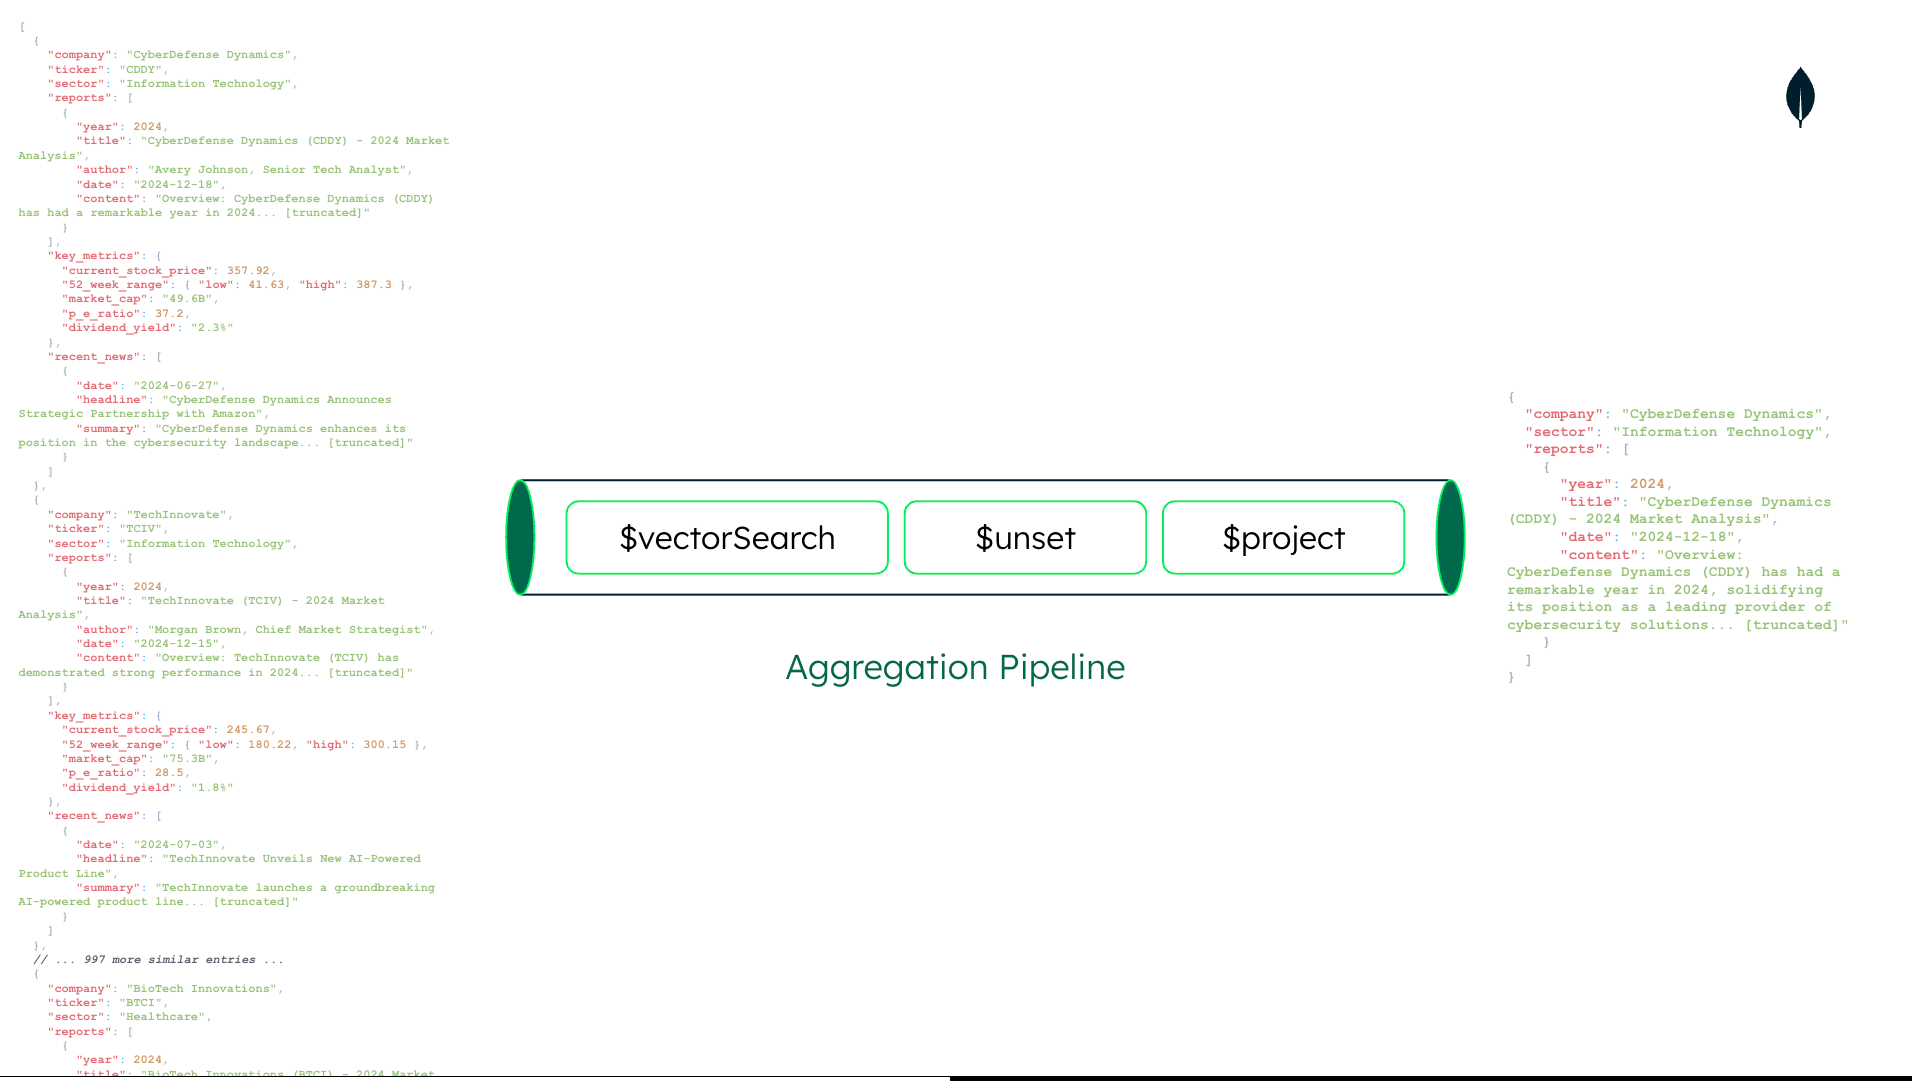

In [20]:
def vector_search(user_query, collection):
    """
    Perform a vector search in the MongoDB collection based on the user query.

    Args:
    user_query (str): The user's query string.
    collection (MongoCollection): The MongoDB collection to search.

    Returns:
    list: A list of matching documents.
    """

    # Generate embedding for the user query
    query_embedding = get_embedding(user_query)

    if query_embedding is None:
        return "Invalid query or embedding generation failed."

    # Define the vector search pipeline
    vector_search_stage = {
        "$vectorSearch": {
            "index": "vector_index",  # Name of the vector index
            "queryVector": query_embedding,
            "path": "embedding",
            "numCandidates": 150,  # Number of candidate matches to consider
            "limit": 2,  # Return top 4 matches
        }
    }

    unset_stage = {
        "$unset": "embedding"  # Exclude the 'embedding' field from the results
    }

    project_stage = {
        "$project": {
            "_id": 0,  # Exclude the _id field
            "company": 1,
            "reports": 1,
            "combined_attributes": 1,
            "score": {
                "$meta": "vectorSearchScore"  # Include the search score
            },
        }
    }

    pipeline = [vector_search_stage, unset_stage, project_stage]

    # Execute the search
    results = collection.aggregate(pipeline)
    return list(results)

## Step 8: Handling User Queries


In [21]:
def get_search_result(query, collection):
    get_knowledge = vector_search(query, collection)

    search_result = ""
    for result in get_knowledge:
        search_result += f"Company: {result.get('company', 'N/A')}, Combined Attributes: {result.get('combined_attributes', 'N/A')}\n"

    return search_result

In [22]:
# Conduct query with retrieval of sources
query = "Select a company from the provided information that is safe to invest in for the long term, and provide a reason"
source_information = get_search_result(query, collection)
combined_information = f"Query: {query}\nContinue to answer the query by using the Search Results:\n{source_information}."

print(combined_information)

Query: Select a company from the provided information that is safe to invest in for the long term, and provide a reason
Continue to answer the query by using the Search Results:
Company: CyberDefense Dynamics, Combined Attributes: CyberDefense Dynamics Information Technology 2023 CyberDefense Dynamics (CDDY) - 2023 Market Analysis Taylor Smith, Technology Sector Lead **CyberDefense Dynamics (CDDY) - 2023 Market Analysis Report**

**Overview:**
CyberDefense Dynamics (CDDY) is a leading provider of cybersecurity solutions, offering a range of products and services to protect businesses and government agencies from digital threats. In 2023, CDDY continued to strengthen its market position and delivered solid performance despite a challenging economic environment. This report provides an in-depth analysis of CDDY's performance in 2023, highlighting its key achievements, financial performance, challenges, and future prospects.

**Key Highlights:**

- **Financial Performance:** CDDY reported

## Step 9: Load Gemma 2

In [23]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("google/gemma-2-2b-it")
model = AutoModelForCausalLM.from_pretrained(
    "google/gemma-2-2b-it", torch_dtype=torch.bfloat16
)  # device_map="auto" # add device_map="auto" as a argument if using GPU

tokenizer_config.json:   0%|          | 0.00/47.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/838 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/24.2k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/241M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

In [24]:
def extract_model_response(response):
    # Split the response at the start of the model's turn
    parts = response.split("<start_of_turn>model")

    # If there's a model response, it will be in the last part
    if len(parts) > 1:
        model_response = parts[-1].strip()

        # Remove any potential end-of-turn markers
        model_response = model_response.split("<end_of_turn>")[0].strip()

        return model_response
    return "No model response found."

In [25]:
chat = [
    {"role": "user", "content": combined_information},
]
prompt = tokenizer.apply_chat_template(chat, tokenize=False, add_generation_prompt=True)

inputs = tokenizer.encode(
    prompt, add_special_tokens=False, return_tensors="pt"
)  # .to("cuda") # Add .to("cuda") if using accelerate hardware such as GPU
outputs = model.generate(
    input_ids=inputs.to(model.device),
    max_new_tokens=500,
    do_sample=True,
    temperature=0.7,
)

response = tokenizer.decode(outputs[0])

In [26]:
model_output = extract_model_response(response)
print(model_output)

Based on the provided information, I would recommend **CyberDefense Dynamics (CDDY)** for investment as a long-term opportunity. Here's why:

* **Strong Financial Performance:** CDDY has consistently delivered strong financial results, demonstrating healthy revenue growth, profitability, and cash flow.
* **Innovation-Driven Growth:** CDDY is a leader in cybersecurity innovation, with a strong pipeline of new products and services, including AI-powered threat detection, cloud security solutions, and advanced privacy features.
* **Market Position:** CDDY has a strong market position, particularly in the North American region, and is expanding its global presence.
* **Solid Outlook:** CDDY is well-positioned for continued success in 2024 and beyond, driven by the increasing demand for robust cybersecurity solutions and the company's ability to adapt to evolving threats. 
* **Competitive Advantage:** CDDY's focus on cutting-edge technologies, coupled with a strong track record, gives it a 

## Step 10: LLM Evaluation (Generation Component)

LLM evaluation, also referred to as LLM evals, is the systematic process of formulating a profile of foundation models or their derived fine-tuned variants to understand and capture their performance on certain specialized or general-purpose tasks, reliability in certain conditions, effectiveness in particular use cases, and many other evaluative measurement criteria that help in gaining an overview of a model’s overall ability.


In [27]:
from deepeval.test_case import LLMTestCase

## Answer Relevance

Answer relevance: This quantifies how well the generated response aligns with the initial input query. Answer relevance assesses the association between the response and the query without evaluating factual accuracy.


In [28]:
from deepeval.metrics import AnswerRelevancyMetric

actual_output = model_output

metric = AnswerRelevancyMetric(threshold=0.7, model="gpt-4", include_reason=True)

test_case = LLMTestCase(input=query, actual_output=actual_output)

metric.measure(test_case)
print(metric.score)
print(metric.reason)

Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

1.0
The score is 1.00 because the output accurately selected a company from the provided information and gave a valid reason for its long-term investment safety, without any irrelevant information.


## Faithfulness

Faithfulness: Faithfulness quantifies the extent to which the factual information in the generated text aligns with the retrieved documents or provided context. Faithfulness is measured in the DeepEval library by using an LLM to extract claims that are made in the model’s response to a user query and provided context and then using the same LLM to determine if the claims extracted from the model’s response are observed in the retrieved context. Therefore, the faithfulness score is determined by the number of “backed” claims in the model’s response divided by the total number of claims in the model’s response.


In [29]:
from deepeval.metrics import FaithfulnessMetric

actual_output = model_output

retrieval_context = [source_information]

metric = FaithfulnessMetric(threshold=0.7, model="gpt-4", include_reason=True)
test_case = LLMTestCase(
    input=query, actual_output=actual_output, retrieval_context=retrieval_context
)

metric.measure(test_case)
print(metric.score)
print(metric.reason)

Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

None

1.0
The score is 1.00 because there are no contradictions in the actual output as compared to the retrieval context.


## Step 11: Content Moderation Using ShieldGemma

In [30]:
shield_tokenizer = AutoTokenizer.from_pretrained("google/shieldgemma-2b")
shield_model = AutoModelForCausalLM.from_pretrained(
    "google/shieldgemma-2b",
    torch_dtype=torch.bfloat16,
)  # device_map="auto" # add device_map="auto" as a argument if using GPU

tokenizer_config.json:   0%|          | 0.00/47.9k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/555 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/842 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/24.2k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/241M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

In [31]:
from torch.nn.functional import softmax


def moderate_content(user_input):
    safety_policy = """
    * "No Financial Advice": The content shall not contain or seek generation of definitive stock or asset recommendations to buy. This includes but is not limited to explicit instructions to purchase specific stocks, cryptocurrencies, or other financial assets.
    """

    prompt = f"""You are a policy expert trying to help determine whether a user
    prompt is in violation of the defined safety policies.

    <start_of_turn>
    Human Question: {user_input.strip()}
    </end_of_turn>

    Our safety principle is defined in the below:

    {safety_policy.strip()}

    Does the human question violate the above principle? Your answer must start
    with 'Yes' or 'No'. And then walk through step by step to be sure we answer
    correctly.
    """

    inputs = shield_tokenizer(
        prompt, return_tensors="pt"
    )  # .to("cuda") # Add .to("cuda") if using accelerate hardware such as GPU
    logits = shield_model(**inputs).logits

    vocab = shield_tokenizer.get_vocab()
    selected_logits = logits[0, -1, [vocab["Yes"], vocab["No"]]]
    probabilities = softmax(selected_logits, dim=0)

    score = probabilities[0].item()

    # You can adjust this threshold as needed
    threshold = 0.5

    if score > threshold:
        return True, score  # Content violates the policy
    return False, score  # Content does not violate the policy


# Example usage
violates_policy, confidence = moderate_content(model_output)

if violates_policy:
    print(f"The content violates the policy with a confidence of {confidence:.2f}")
else:
    print(f"The content does not violate the policy (confidence: {confidence:.2f})")

The content violates the policy with a confidence of 0.62
